# Extract Number of Eye Blinks per Epoch

# Import Libraries

In [1]:
# Import libraries
import mne
import json
import numpy as np
import pandas as pd
import scipy.signal as signal
from scipy.signal import butter, filtfilt, find_peaks
from scipy.stats import zscore
import matplotlib.pyplot as plt

# Import custom scripts
from Functions import import_data
from Functions import data_tools
from Functions import processing

# Enable interactive plots
%matplotlib qt

# Import Data

In [2]:
# Load list of files to import
files = [  
    "sub-P001_ses-S001_task-T1_run-001_eeg",
    "sub-P002_ses-S001_task-T1_run-001_eeg",
    "sub-P003_ses-S001_task-T1_run-001_eeg",
    "sub-P004_ses-S001_task-T1_run-001_eeg",
    "sub-P005_ses-S001_task-T1_run-001_eeg",
    "sub-P006_ses-S001_task-T1_run-001_eeg",
    "sub-P007_ses-S001_task-T1_run-001_eeg",
    "sub-P008_ses-S001_task-T1_run-001_eeg", 
    "sub-P009_ses-S001_task-T1_run-001_eeg",
    "sub-P010_ses-S001_task-T1_run-001_eeg",  
]

# Get unique subject IDs
subject_ids = [file.split('_')[0] for file in files]
unique_subject_ids = list(set(subject_ids))

# Preallocate eeg_ts, eeg_data, eeg_fs
eeg_ts =   [None] * len(files)
eeg_data = [None] * len(files)
raw_eeg =  [None] * len(files)

ch_names = ["Fz", "F4", "F8", "C3", "Cz", "C4", "T8", "P7", "P3", "P4", "P8", "PO7", "PO8", "O1", "Oz", "O2"]

for f, file in enumerate(files):
    for sub in subject_ids:
        if sub == file.split('_')[0]:
            [eeg_ts[f], eeg_data[f], eeg_fs] = import_data.read_xdf(f"Data\\Pilot2\\EEG\\{sub}\\ses-S001\\eeg\\{file}.xdf", picks=ch_names)

            # Create MNE array
            info = mne.create_info(ch_names, eeg_fs, ch_types = 'eeg')  # Create info properties
            raw_eeg[f] = mne.io.RawArray(eeg_data[f], info = info)            

            # Set standard channel montage
            raw_eeg[f].set_montage('standard_1020')

Creating RawArray with float64 data, n_channels=16, n_times=207136
    Range : 0 ... 207135 =      0.000 ...   809.121 secs
Ready.
Creating RawArray with float64 data, n_channels=16, n_times=194944
    Range : 0 ... 194943 =      0.000 ...   761.496 secs
Ready.
Creating RawArray with float64 data, n_channels=16, n_times=199168
    Range : 0 ... 199167 =      0.000 ...   777.996 secs
Ready.
Creating RawArray with float64 data, n_channels=16, n_times=201344
    Range : 0 ... 201343 =      0.000 ...   786.496 secs
Ready.
Creating RawArray with float64 data, n_channels=16, n_times=195456
    Range : 0 ... 195455 =      0.000 ...   763.496 secs
Ready.
Creating RawArray with float64 data, n_channels=16, n_times=196992
    Range : 0 ... 196991 =      0.000 ...   769.496 secs
Ready.
Creating RawArray with float64 data, n_channels=16, n_times=200960
    Range : 0 ... 200959 =      0.000 ...   784.996 secs
Ready.
Creating RawArray with float64 data, n_channels=16, n_times=190080
    Range : 0 ..

# Filter Data

Processing file 1/10: sub-P001_ses-S001_task-T1_run-001_eeg for subject sub-P001
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 5.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Filter length: 1691 samples (6.605 s)

Processing file 2/10: sub-P002_ses-S001_task-T1_run-001_eeg for subject sub-P002
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband 

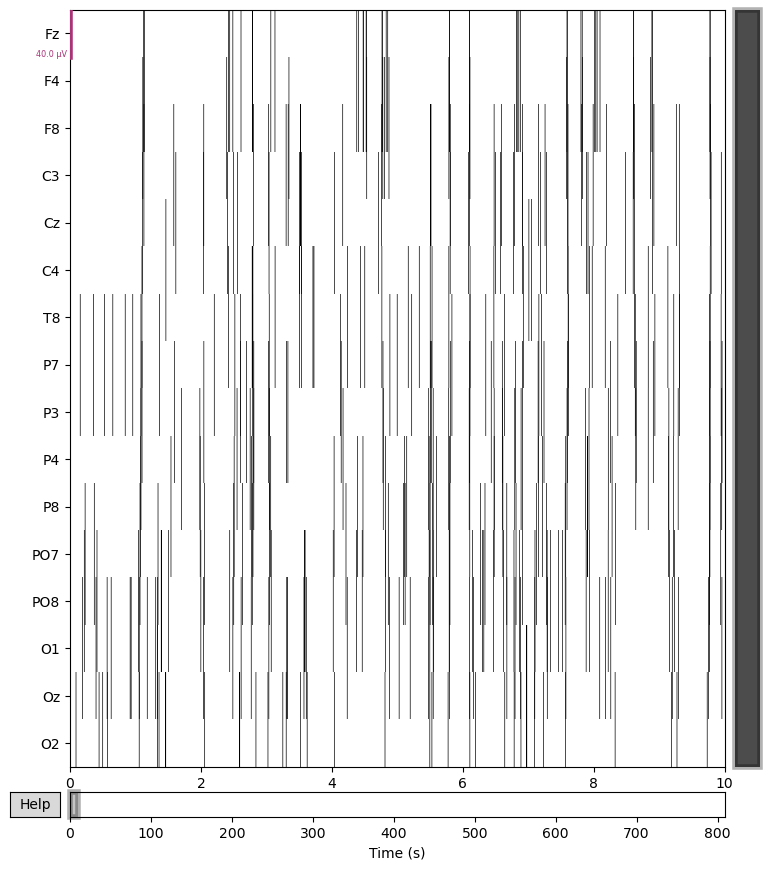

In [3]:
# Preallocate lists for filtered data
filt_raw = [None] * len(files)

# Loop through each file and corresponding raw EEG
for f, file in enumerate(files):
    subject_id = file.split('_')[0]
    print(f"Processing file {f+1}/{len(files)}: {file} for subject {subject_id}")

    raw = raw_eeg[f]
    # Filter EEG data by frequency bands
    filt_raw[f] = raw.copy().filter(l_freq=0.5, h_freq=5, picks=ch_names)
    
filt_raw[0].plot()

# Fix P001 Labels

In [4]:
[marker_ts_P001, markers_P001] = import_data.read_xdf_unity_markers(f"Data\\Pilot2\\EEG\\sub-P001\\ses-S001\\eeg\\sub-P001_ses-S001_task-T1_run-001_eeg.xdf")

for temp in markers_P001:
    if temp[0] == "stimulus ended, getting score":
        temp[0] = "bleh" 

epoch_end_P001 = "stimulus ended"

# Epoch Data

In [5]:
list_of_events = [] # same for all files

# Initialize lists for markers and marker timestamps
markers = [None] * len(files)
marker_ts = [None] * len(files)

# Initialize lists for epochs and EEG data for each frequency band
eeg_epochs = [None] * len(files)
events_epochs = [None] * len(files)
epochs_organized = [None] * len(files)

# Create a list of unique events
for x in range(4):
    for y in range(3):
        list_of_events.append(f"Contrast{x+1}Size{y+1}")

epoch_end = "getting score"

# Create a dict of stimuli using the unique events
dict_of_stimuli = {i: event for i, event in enumerate(list_of_events)}

for f, file in enumerate(files):
    for sub in subject_ids:
        if sub == file.split('_')[0]:
            if sub == "sub-P001": # Using special labels for P001
                [events_epochs[0], eeg_epochs[0]] = data_tools.create_epochs(
                        eeg_data = filt_raw[0].get_data(), 
                        eeg_ts = eeg_ts[0],
                        markers = markers_P001,
                        markers_ts = marker_ts_P001,
                        events = list_of_events,
                        epoch_end = epoch_end_P001
                )
            else:  # For all other subjects
                [marker_ts[f], markers[f]] = import_data.read_xdf_unity_markers(f"Data\\Pilot2\\EEG\\{sub}\\ses-S001\\eeg\\{file}.xdf") # Import marker

                [events_epochs[f], eeg_epochs[f]] = data_tools.create_epochs(
                    eeg_data = filt_raw[f].get_data(), ############
                    eeg_ts = eeg_ts[f],
                    markers = markers[f],
                    markers_ts = marker_ts[f],
                    events = list_of_events,
                    epoch_end = epoch_end 
               )

# Organize epochs by stimuli and frequency
for f, file in enumerate(files):
    epochs_organized[f] = data_tools.epochs_stim(eeg_epochs = eeg_epochs[f], labels = events_epochs[f], stimuli = dict_of_stimuli)
    
    for stim_idx, stim_label in dict_of_stimuli.items():
        stim_epochs = epochs_organized[f][stim_idx]
        
        if len(stim_epochs) > 0:
            print(f"Stimulus: {stim_label}, Shape: {stim_epochs.shape}")
        else:
            print(f"Stimulus: {stim_label}, No epochs found")

Stimulus: Contrast1Size1, Shape: (3, 16, 1560)
Stimulus: Contrast1Size2, Shape: (3, 16, 1560)
Stimulus: Contrast1Size3, Shape: (2, 16, 1560)
Stimulus: Contrast2Size1, Shape: (3, 16, 1560)
Stimulus: Contrast2Size2, Shape: (4, 16, 1560)
Stimulus: Contrast2Size3, Shape: (2, 16, 1560)
Stimulus: Contrast3Size1, Shape: (3, 16, 1560)
Stimulus: Contrast3Size2, Shape: (2, 16, 1560)
Stimulus: Contrast3Size3, Shape: (4, 16, 1560)
Stimulus: Contrast4Size1, Shape: (4, 16, 1560)
Stimulus: Contrast4Size2, Shape: (4, 16, 1560)
Stimulus: Contrast4Size3, Shape: (6, 16, 1560)
Stimulus: Contrast1Size1, Shape: (3, 16, 1279)
Stimulus: Contrast1Size2, Shape: (2, 16, 1279)
Stimulus: Contrast1Size3, Shape: (2, 16, 1279)
Stimulus: Contrast2Size1, Shape: (3, 16, 1279)
Stimulus: Contrast2Size2, Shape: (2, 16, 1279)
Stimulus: Contrast2Size3, Shape: (4, 16, 1279)
Stimulus: Contrast3Size1, Shape: (5, 16, 1279)
Stimulus: Contrast3Size2, Shape: (5, 16, 1279)
Stimulus: Contrast3Size3, Shape: (3, 16, 1279)
Stimulus: Con

In [ ]:
def count_eye_blinks(eeg_epochs, sfreq, channel_names, frontal_channels=['Fz', 'F4'], z_thresh=2, min_dist_ms=300):
    """
    Count eye blinks per epoch from raw EEG using frontal channels.
    
    Parameters:
        eeg_epochs: np.ndarray, shape (n_epochs, n_channels, n_samples)
        sfreq: int or float, sampling frequency
        channel_names: list of str, length n_channels
        frontal_channels: list of str, names of frontal channels to use
        z_thresh: float, z-score threshold for blink peak detection
        min_dist_ms: int, minimum time (ms) between blinks

    Returns:
        blink_counts: list of int, number of blinks per epoch
    """
    frontal_idxs = [i for i, ch in enumerate(channel_names) if ch in frontal_channels]
    if not frontal_idxs:
        raise ValueError("No frontal channels found in data.")

    blink_counts = []
    min_distance = int((min_dist_ms / 1000) * sfreq)

    for epoch in eeg_epochs:
        # Average frontal channels
        frontal_avg = np.mean(epoch[frontal_idxs, :], axis=0)

        # Z-score normalization
        z_data = zscore(frontal_avg)

        # Detect peaks
        peaks, _ = find_peaks(z_data, height=z_thresh, distance=min_distance)

        blink_counts.append(len(peaks))

    return blink_counts

In [9]:
for f, file in enumerate(files):
    for stim_idx, stim_label in dict_of_stimuli.items():
        stim_epochs = epochs_organized[f][stim_idx]

        if stim_epochs.shape[0] > 0:
            blink_counts = count_eye_blinks(
                eeg_epochs=stim_epochs,
                sfreq=eeg_fs,
                channel_names=ch_names
            )
            print(f"{stim_label}: {blink_counts}")
        else:
            print("ERROR")

Contrast1Size1: [5, 4, 5]
Contrast1Size2: [7, 3, 4]
Contrast1Size3: [6, 4]
Contrast2Size1: [4, 4, 5]
Contrast2Size2: [6, 6, 5, 3]
Contrast2Size3: [5, 3]
Contrast3Size1: [4, 3, 3]
Contrast3Size2: [6, 6]
Contrast3Size3: [6, 5, 4, 4]
Contrast4Size1: [3, 4, 3, 3]
Contrast4Size2: [3, 3, 4, 4]
Contrast4Size3: [5, 4, 4, 3, 4, 4]
Contrast1Size1: [2, 3, 2]
Contrast1Size2: [1, 3]
Contrast1Size3: [2, 4]
Contrast2Size1: [1, 1, 2]
Contrast2Size2: [1, 3]
Contrast2Size3: [2, 3, 1, 1]
Contrast3Size1: [2, 1, 0, 2, 1]
Contrast3Size2: [1, 2, 1, 1, 1]
Contrast3Size3: [1, 2, 0]
Contrast4Size1: [2, 2, 1, 1, 1]
Contrast4Size2: [2, 1, 1]
Contrast4Size3: [0, 1, 2]
Contrast1Size1: [1, 3, 2]
Contrast1Size2: [1, 1]
Contrast1Size3: [2, 2]
Contrast2Size1: [1, 1, 2, 3]
Contrast2Size2: [1, 2, 3]
Contrast2Size3: [3, 2]
Contrast3Size1: [1, 2, 1, 3, 3]
Contrast3Size2: [1, 1, 3]
Contrast3Size3: [1, 2, 2]
Contrast4Size1: [2, 4, 2, 2, 2]
Contrast4Size2: [1, 2, 2]
Contrast4Size3: [1, 1, 3, 4, 2]
Contrast1Size1: [2, 2]
Contr